

# NETFLIX Content Based Recommandation System (CB-RS)


"*TV Shows and Movies listed on Netflix*

*This dataset consists of tv shows and movies available on Netflix as of 2019. The dataset is collected from Flixable which is a third-party Netflix search engine.*"


# The Goal

The goal of this project is to write a RS for movie/TV shows based on the Netflix data.

In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import nltk # Natural Language Toolkit
import datetime
from string import punctuation
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.corpus import wordnet 
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer #Lemmatization

In [27]:
def get_wordnet_pos(word):
    
    """
    Map POS tag to first character (for lemmatization)
    :param word: a word in your dataset
    :return: Part of speech tag
    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Step 1: Data collection - Read the data

The Dataset was collected on [Kaggle](https://www.kaggle.com/shivamb/netflix-shows).

In [28]:
netfilx_raw_data = pd.read_csv("netflix_titles.csv") 

In [29]:
netfilx_raw_data.head(100) #Let see the first rows

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...
1,80117401,Movie,Jandino: Whatever it Takes,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...
2,70234439,TV Show,Transformers Prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,Kids' TV,"With the help of three human allies, the Autob..."
3,80058654,TV Show,Transformers: Robots in Disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,Kids' TV,When a prison ship crash unleashes hundreds of...
4,80125979,Movie,#realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,Comedies,When nerdy high schooler Dani finally attracts...
...,...,...,...,...,...,...,...,...,...,...,...,...
95,81016750,Movie,The 3rd Eye,Rocky Soraya,"Jessica Mila, Denny Sumargo, Citra Prima, Bian...",Indonesia,"September 28, 2018",2018,TV-MA,108 min,"Horror Movies, International Movies",When her little sister claims she sees the dea...
96,81002866,Movie,The Sinking Of Van Der Wijck,Sunil Soraya,"Herjunot Ali, Pevita Pearce, Reza Rahadian, Ra...",Indonesia,"September 28, 2018",2013,TV-14,163 min,"Dramas, International Movies, Romantic Movies",When a young man leaves home to fulfill the wi...
97,80992039,Movie,Two Catalonias,"Álvaro Longoria, Gerardo Olivares",NaN,Spain,"September 28, 2018",2018,TV-MA,117 min,"Documentaries, International Movies",Lawmakers and activists with conflicting ideol...
98,80126507,Movie,Bobby Sands: 66 Days,Brendan Byrne,NaN,"Ireland, United Kingdom","September 28, 2017",2016,TV-14,106 min,Documentaries,"In 1981, an imprisoned Irish Republican Army s..."


The dataset contains 12 descriptors (columns):
- Show_id (int)
- type (str)
- director (str)
- cast (str)
- country (str)
- date_added (str)
- release_year (int)
- rating (str)
- duration (str)
- listed_in (str)
- description (str)

# Step 2: Let's visualize and clean the data for CB-RS 

## Overview on the dataset

In [30]:
netfilx_raw_data.info() #get some info about the dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6234 entries, 0 to 6233
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       6234 non-null   int64 
 1   type          6234 non-null   object
 2   title         6234 non-null   object
 3   director      4265 non-null   object
 4   cast          5664 non-null   object
 5   country       5758 non-null   object
 6   date_added    6223 non-null   object
 7   release_year  6234 non-null   int64 
 8   rating        6224 non-null   object
 9   duration      6234 non-null   object
 10  listed_in     6234 non-null   object
 11  description   6234 non-null   object
dtypes: int64(2), object(10)
memory usage: 584.6+ KB


## Distribution TV shows/Movies - Donut chart ( like a pie chart but more cool ;) )

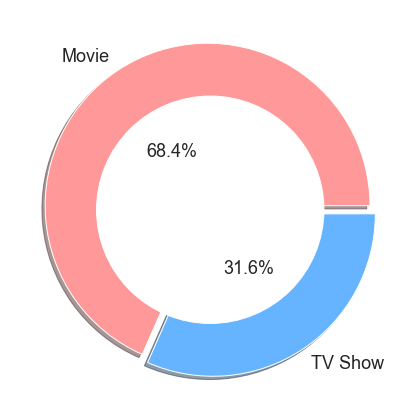

In [31]:
fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(aspect="equal"))
wedges, texts, autotexts = ax.pie(netfilx_raw_data.type.value_counts(),
                                  explode=(0.03,0.03),labels=netfilx_raw_data.type.value_counts().index,
                                  colors=['#ff9999','#66b3ff'],autopct='%1.1f%%', shadow=True,pctdistance=0.4)

plt.setp(texts, size=18)
plt.setp(autotexts, size=18)

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.tight_layout()
plt.show()


Here we can see that movies represent the larger part of this dataset (68.4%)

## Release per year (2011 - 2018)

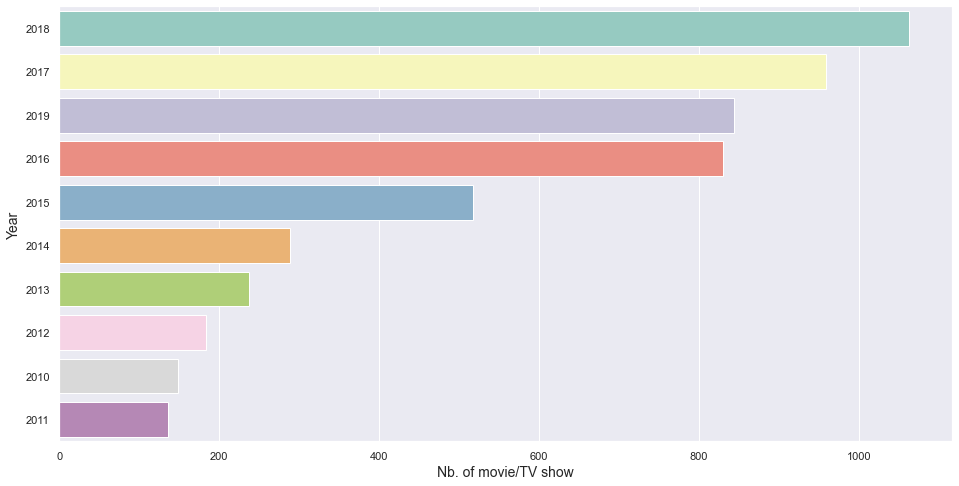

In [32]:
plt.figure(figsize=(16,8))
ax = sns.countplot(y='release_year', data=netfilx_raw_data,
                   order=netfilx_raw_data['release_year'].value_counts().index[0:10],
                   palette="Set3")
plt.xlabel("Nb. of movie/TV show",fontsize=14)
plt.ylabel("Year",fontsize=14)
plt.show()


## Release per Country (Top 10)

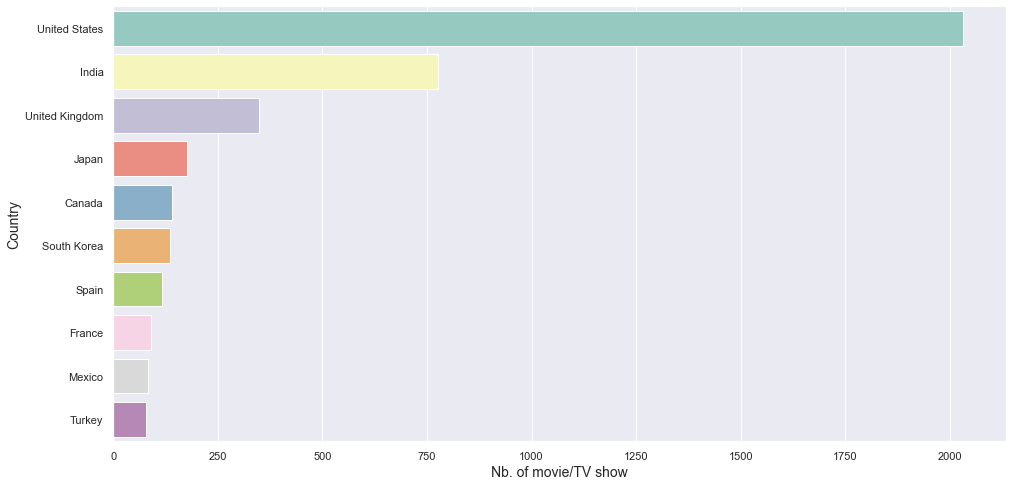

In [33]:
plt.figure(figsize=(16,8))
ax = sns.countplot(y='country', data=netfilx_raw_data,
                   order=netfilx_raw_data['country'].value_counts().index[0:10],
                   palette="Set3")
plt.xlabel("Nb. of movie/TV show",fontsize=14)
plt.ylabel("Country",fontsize=14)
plt.show()

## Nb. of realease per month

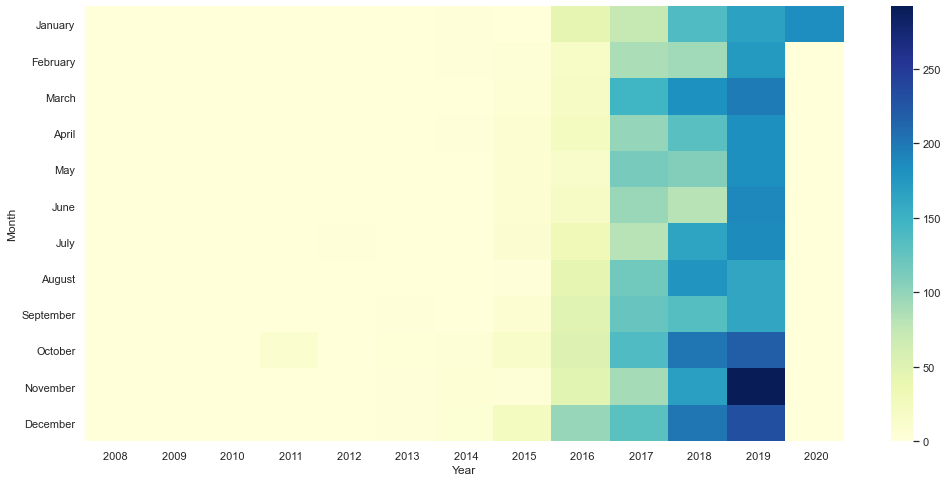

In [34]:
months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September',\
          'October', 'November', 'December']
date_of_realease = netfilx_raw_data[['date_added']].dropna()

# Get Months and Years
date_of_realease['Year'] = date_of_realease['date_added'].apply(lambda date : date.split(',')[-1]) #Get Month
date_of_realease['Month'] = date_of_realease['date_added'].apply(lambda date : date.split()[0]) #Get Year


realese_date_df = date_of_realease.groupby('Year')['Month']
realese_date_df = realese_date_df.value_counts().unstack().fillna(0)[months]

ax = plt.subplots(figsize=(17, 8))
sns.heatmap(realese_date_df.T, cmap="YlGnBu") # beatiful sns plot 
plt.show()

## Movie duration distribution

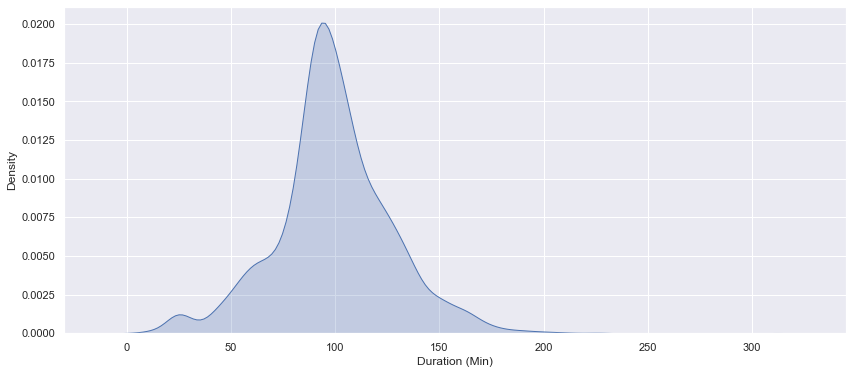


Average duration of a movie: 99.101 min
Standard diviation: 28.072 min



In [35]:
netfilx_movies = netfilx_raw_data[netfilx_raw_data['type'] == "Movie"]
netfilx_duration = netfilx_movies["duration"].str.replace(' min','').astype(int)

plt.subplots(figsize=(14, 6))
sns.set(style="darkgrid")
sns.kdeplot(data=netfilx_duration, shade=True)
plt.xlabel("Duration (Min)")
plt.show()

print("""
Average duration of a movie: {0} min
Standard diviation: {1} min
""".format(round(np.mean(netfilx_duration),3),round(np.std(netfilx_duration),3)))

## Word Clouds  

In [53]:
netfilx_raw_data = pd.read_csv("netflix_titles.csv") 
list_stopwords = stopwords.words('english')

lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(word,get_wordnet_pos(word)) for word in text]

for descriptors in ['title','listed_in','description']:
    netfilx_raw_data[descriptors] = netfilx_raw_data[descriptors].dropna() #remove NA
    netfilx_raw_data[descriptors] = netfilx_raw_data[descriptors].str.lower() #lower everything
    netfilx_raw_data[descriptors] = netfilx_raw_data[descriptors].str.replace('[^\w\s]','') #remove ponctuations
    netfilx_raw_data[descriptors] = netfilx_raw_data[descriptors].apply(word_tokenize) #tokenization
    netfilx_raw_data[descriptors] = netfilx_raw_data[descriptors]\
    .apply(lambda x: [word for word in x if word not in list_stopwords]) #remove stopwords
    netfilx_raw_data[descriptors] = netfilx_raw_data[descriptors].apply(lemmatize_text) #lemmatize
    netfilx_raw_data[descriptors] = netfilx_raw_data[descriptors].str.join(" ") #join everything

netfilx_raw_data.head()


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,81145628,Movie,norm north king size adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China","September 9, 2019",2019,TV-PG,90 min,child family movie comedy,planning awesome wedding grandfather polar bea...
1,80117401,Movie,jandino whatever take,NaN,Jandino Asporaat,United Kingdom,"September 9, 2016",2016,TV-MA,94 min,standup comedy,jandino asporaat riff challenge raise kid sere...
2,70234439,TV Show,transformer prime,NaN,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,"September 8, 2018",2013,TV-Y7-FV,1 Season,kid tv,help three human ally autobots protect earth o...
3,80058654,TV Show,transformer robot disguise,NaN,"Will Friedle, Darren Criss, Constance Zimmer, ...",United States,"September 8, 2018",2016,TV-Y7,1 Season,kid tv,prison ship crash unleashes hundred decepticon...
4,80125979,Movie,realityhigh,Fernando Lebrija,"Nesta Cooper, Kate Walsh, John Michael Higgins...",United States,"September 8, 2017",2017,TV-14,99 min,comedy,nerdy high schooler dani finally attracts inte...


### Word Clouds - Description

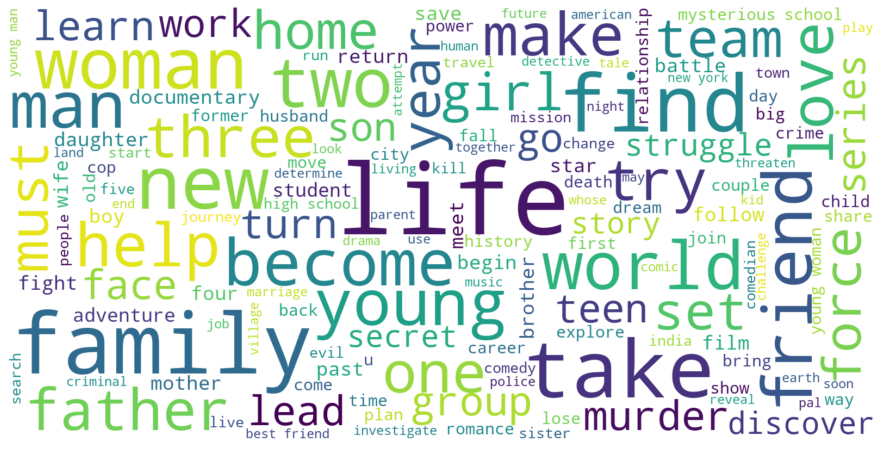

In [48]:
description = list(netfilx_raw_data['description'])
wordcloud = WordCloud(width=1600, height=800,max_font_size=180, max_words=150,background_color="white").generate(" ".join(description))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()


### Word Clouds - Title 

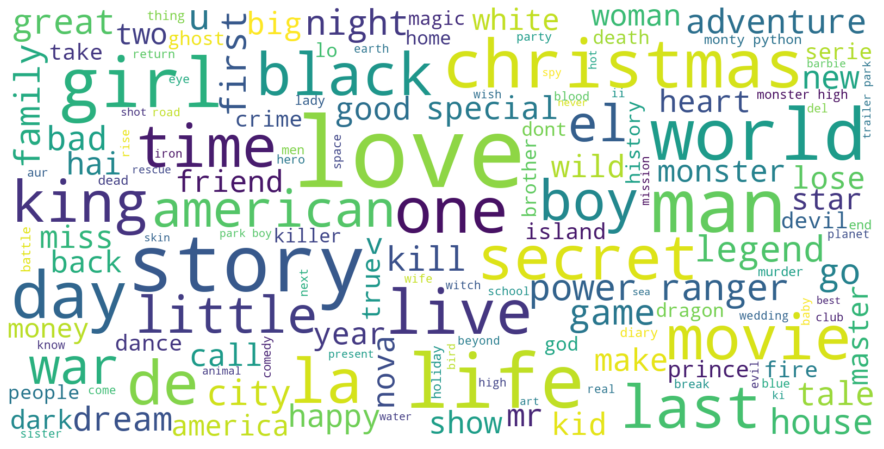

In [49]:
title = list(netfilx_raw_data['title'])
wordcloud = WordCloud(width=1600, height=800,max_font_size=180, max_words=150,background_color="white").generate(" ".join(title))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()


### Word Clouds - Movie type

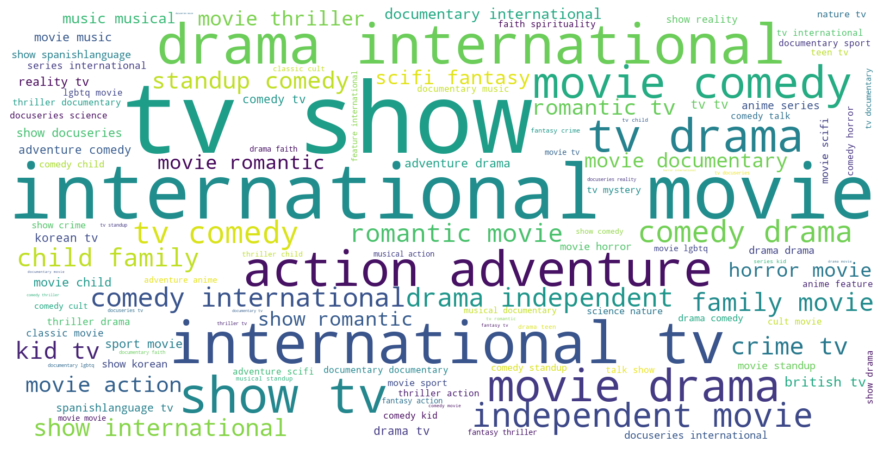

In [50]:
movie_type = list(netfilx_raw_data['listed_in'])
wordcloud = WordCloud(width=1600, height=800,max_font_size=180, max_words=150,background_color="white").generate(" ".join(movie_type))
plt.figure(figsize=(16,8))
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis("off")
plt.show()

### Let's see if there is missing values on the dataset

In [51]:
netfilx_raw_data.isnull().sum()

show_id            0
type               0
title              0
director        1969
cast             570
country          476
date_added        11
release_year       0
rating            10
duration           0
listed_in          0
description        0
dtype: int64

As we can see the columns 'directiors', 'cast', 'country', 'date_added' and 'rating' contain missing value. The easiest eway would be to remove all rows contains missing value. However, this will lead to the loss of a significant amount of data. Here, I decided to remove all columns that contain missing values (even if interresting information for the RS design will be remove, e.g. cast).

The new dataset will only includes:
- type
- title
- listed_in
- description

In [52]:
netfilx_raw_data.drop(["show_id","director","cast","country","date_added","release_year","rating","duration"],axis=1,inplace=True)